# SN Ia Mass-Step Calibration with Ising Marginalization

Calibrate a mock SN Ia sample with a binary **host-mass step**, comparing:
- **Ising-marginalized:** propagates uncertainty in host-mass classification, and
- **Fixed assignment:** deterministic split at the mass threshold, ignoring the uncertainty in the host-mass.

**Outputs.** Posterior summaries for $\gamma, \log_{10} M_\star, M_B, H_0, \Omega_m$, and optionally $\Omega_k$; 2D marginalized posterior; diagnostic text; and saved figures.

> Figures will not exactly match the paper because the mock data are re-randomized on each run. Qualitative agreement and trends remain the same.

## Reproducibility & Setup

- Mock datasets are generated using a fixed random seed, ensuring identical results when the notebook is re-executed from a fresh kernel. However, re-running individual cells within an existing session regenerates the mock data, which causes (expected) variations in the posterior credible intervals and figure appearances. These variations are purely statistical; the comparative conclusions and overall trends remain unchanged.
- The notebook auto-creates `data/`, `output/`, and `plots/` in the working folder.

## Data: Pantheon+ & SH0ES

We load the Pantheon+ supernova metadata and the SH0ES Table 6 Cepheid distances.

**References.**  
- B22: The Pantheon+ Analysis: Cosmological Constraints (Brout et al. 2022), ApJ 938, 110  https://iopscience.iop.org/article/10.3847/1538-4357/ac8e04
- R22: A Comprehensive Measurement of the Local Value of the Hubble Constant with $1 \, \mathrm{km \, s^{−1} \, Mpc^{−1}}$ Uncertainty from the Hubble Space Telescope and the SH0ES Team (Riess et al. 2022), ApJL 934, L7  https://iopscience.iop.org/article/10.3847/2041-8213/ac5c5b

### How to run

1. Place `Pantheon+SH0ES.dat` and `table6.txt` in `./data/`.  
2. Run all cells.  
3. Artifacts:
   - Plots in `./plots/`
   - Chains & diagnostics in `./output/`



In [1]:
# ============================================================
# IMPORT PACKAGES
# ============================================================
import os
import random
import time
import emcee
import corner
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import curve_fit
from pathlib import Path


In [2]:
# ============================================================
# PREPARE FOLDERS
# ============================================================
for d in ['data', 'output', 'plots']:
    os.makedirs(d, exist_ok=True)
print("Folders ready: data/, output/, plots/")


Folders ready: data/, output/, plots/


In [3]:
# ============================================================
# PHYSICAL CONSTANTS
# ============================================================
c_light = 299792.458 # km/s


In [4]:
# ============================================================
# SET PARAMETERS
# ============================================================

### Which SNe to include ###
z_cut_SH0ES = False # SH0ES-calibration SNe?
high_z_cut  = False # high-z cut-off?
z_cut_lo = 0.023 # low-z cut-off
z_cut_hi = 0.15 # high-z cut-off

incl_Omega_k = False # fit Omega_k?

err_logmass_method = 0.2 # method-uncertainty of log-mass

max_n = 2 * 10**4 # max no. MCMC iterations

file_postfix = 'make_your_choice' # for saving files

np.random.seed(7); random.seed(7) # set seed, for reproducibility


In [5]:
# ============================================================
# MODEL PARAMETERS: True values
# ============================================================
gamma_true = 0.05 # mass-step magnitude
logmass_star_true = 10.0 # transition log-mass

err_mB_true = 0.15 # uncertainty in magnitude

MB_true = -19.253 # R22
err_M_B = 0.027 # R22
H0_true = 73.0 # R22
M_intercept_true = 25.0 + MB_true + 5.0 * np.log10( c_light / H0_true )

Omega_m_true = 0.3
Omega_k_true = 0.0


## Data: Pantheon+ & SH0ES

Align calibrators by SN name, and apply one of the redshift/selection masks (SH0ES-like or $z>0.023$). Duplicate SN entries in Pantheon+ are dropped (keep first).


In [6]:
# ============================================================
# IMPORT DATA
# ============================================================

### Pantheon+ (B22) ###
file_path_PP = Path("./data/Pantheon+SH0ES.dat")
if not file_path_PP.is_file():
    sys.exit(f"ERROR: Missing data file: {file_path_PP.resolve()}")

data_PP = np.genfromtxt(file_path_PP, names=True, dtype=None, encoding=None) # import data

# Assign to variables
CID              = data_PP["CID"]
IS_CALIBRATOR    = data_PP["IS_CALIBRATOR"]
USED_IN_SH0ES_HF = data_PP["USED_IN_SH0ES_HF"]
z                = data_PP["zHD"]
HOST_RA          = data_PP["HOST_RA"]
HOST_DEC         = data_PP["HOST_DEC"]
logmass          = data_PP["HOST_LOGMASS"]
err_logmass      = data_PP["HOST_LOGMASS_ERR"]

# Manual renamings to conform with Tab. 6 of R22
CID = np.char.replace(CID, "2005df_ANU", "2005df")
CID = np.char.replace(CID, "2008fv_comb", "2008fv")


### SH0ES (R22) ###
file_path_tab6 = Path('./data/table6.txt')
if not file_path_tab6.is_file():
    sys.exit(f"ERROR: Missing data file: {file_path_tab6.resolve()}")
    
names = ('N', 'Host', 'SN',	'${m}_{B,i}^{0}$', 'sigma_mB0',	'mu_Ceph', 'sigma_mu_Ceph',
         '${M}_{B,i}^{0}$', 'sigma_MB0', 'mu_host', 'sigma_mu_host', 'R')
fmt   = (np.float32, 'S10', 'S30', np.float32, np.float32, np.float32, np.float32,
         np.float32, np.float32, np.float32, np.float32, np.float32)
data_tab6 = np.loadtxt(file_path_tab6, unpack=True, skiprows=3, dtype = {'names': names, 'formats': fmt}) # import data

# Assign to variables
_, host, SN, _, _, mu_Ceph, err_mu_Ceph, _, _, _, _, _ = data_tab6
host = host.astype('str')
SN   = SN.astype('str')


In [7]:
# ============================================================
# TRIM DATA
# ============================================================

### Remove duplicates ###
_, unique_idx    = np.unique(CID, return_index=True) # find unique CIDs and keep only first occurrence
unique_idx       = np.sort(unique_idx) # sort indices so the original order is preserved
CID              = CID[unique_idx] # apply to all arrays...
IS_CALIBRATOR    = IS_CALIBRATOR[unique_idx]
USED_IN_SH0ES_HF = USED_IN_SH0ES_HF[unique_idx]
z                = z[unique_idx]
HOST_RA          = HOST_RA[unique_idx]
HOST_DEC         = HOST_DEC[unique_idx]
logmass          = logmass[unique_idx]
err_logmass      = err_logmass[unique_idx]

### Redshift cuts ###
if z_cut_SH0ES:
    mask = (USED_IN_SH0ES_HF == 1) | (IS_CALIBRATOR == 1)
    CID              = CID[mask]
    IS_CALIBRATOR    = IS_CALIBRATOR[mask]
    USED_IN_SH0ES_HF = USED_IN_SH0ES_HF[mask]
    z                = z[mask]
    HOST_RA          = HOST_RA[mask]
    HOST_DEC         = HOST_DEC[mask]
    logmass          = logmass[mask]
    err_logmass      = err_logmass[mask]

else:
    mask = (z > z_cut_lo) | (IS_CALIBRATOR == 1)
    CID              = CID[mask]
    IS_CALIBRATOR    = IS_CALIBRATOR[mask]
    USED_IN_SH0ES_HF = USED_IN_SH0ES_HF[mask]
    z                = z[mask]
    HOST_RA          = HOST_RA[mask]
    HOST_DEC         = HOST_DEC[mask]
    logmass          = logmass[mask]
    err_logmass      = err_logmass[mask]

    if high_z_cut:
        mask = (z < z_cut_hi) | (IS_CALIBRATOR == 1)
        CID              = CID[mask]
        IS_CALIBRATOR    = IS_CALIBRATOR[mask]
        USED_IN_SH0ES_HF = USED_IN_SH0ES_HF[mask]
        z                = z[mask]
        HOST_RA          = HOST_RA[mask]
        HOST_DEC         = HOST_DEC[mask]
        logmass          = logmass[mask]
        err_logmass      = err_logmass[mask]


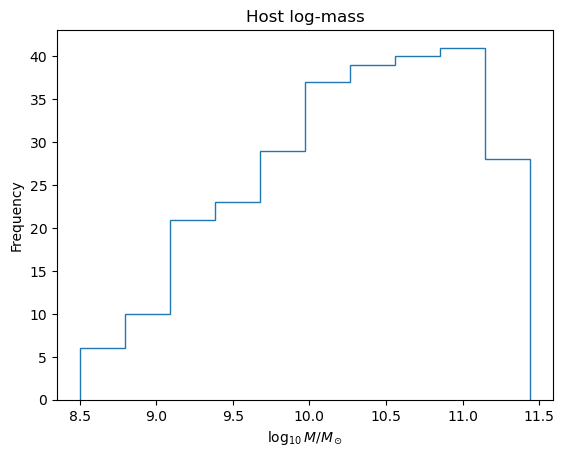

In [8]:
# ============================================================
# DATA ALIGNMENT AND HOST-MASS SAMPLE SELECTION
# ============================================================

### Indices ###
idx_Cal = np.where(IS_CALIBRATOR == 1)[0] # to identify calibrators vs HF SNe
idx_HF  = np.where(IS_CALIBRATOR == 0)[0]

### Map: SN name -> (mu_Ceph, err_mu_Ceph) ###
SN_2_mu_Ceph = {SN[i]: (float(mu_Ceph[i]), float(err_mu_Ceph[i])) for i in range(len(SN))}

# Align Cepheid distances to the Pantheon+ ordering
mu_Ceph_true = np.full_like(z, fill_value=np.nan, dtype=float)
err_mu_Ceph_true  = np.full_like(z, fill_value=np.nan, dtype=float)
for i in idx_Cal:
    key = CID[i]
    if key in SN_2_mu_Ceph:
        mu_Ceph_true[i], err_mu_Ceph_true[i] = SN_2_mu_Ceph[key]
    else:
        raise KeyError(f"Could not find Cepheid entry for calibrator CID/SN '{key}'.")

### Select reliable host–mass estimates for modeling the log-mass uncertainty ###
# The Pantheon+ catalog contains some placeholder and poorly constrained values.
# We keep only entries with well-defined host coordinates and physically plausible
# stellar masses and uncertainties.
mask = (HOST_RA != -999) & (HOST_DEC != -999) # well-defined host coordinates
z_mask           = z[mask]
HOST_RA_mask     = HOST_RA[mask]
HOST_DEC_mask    = HOST_DEC[mask]
logmass_mask     = logmass[mask]
err_logmass_mask = err_logmass[mask]

# Physically plausible stellar masses and uncertainties
mask = (err_logmass_mask != -9.) & (err_logmass_mask < 5.) & (logmass_mask != 7.) & (logmass_mask != 10.) & (logmass_mask != 11.5)
z_mask           = z_mask[mask]
HOST_RA_mask     = HOST_RA_mask[mask]
HOST_DEC_mask    = HOST_DEC_mask[mask]
logmass_mask     = logmass_mask[mask]
err_logmass_mask = err_logmass_mask[mask]

err_logmass_mask_orig = err_logmass_mask

### Plot ###
plt.hist(logmass_mask, histtype="step")
plt.title("Host log-mass")
plt.xlabel(r'$\log_{10} M / M_\odot$')
plt.ylabel("Frequency")

plt.show()


## Host-Mass Uncertainty vs. Redshift

We fit a simple **power-law** (default) or **linear** model for the statistical uncertainty $\delta_i^\mathrm{stat}(z)$, and add in quadrature a method floor $\delta_\mathrm{meth}$ (default 0.5 dex) to obtain

$\delta_i^\mathrm{tot}(z)\;=\;\sqrt{\delta_i^\mathrm{stat}(z)^2+\delta_\mathrm{meth}^2}\,.$


y = c (1+x)^n with c = 0.04928 ± 0.004582, n = 3.544 ± 0.4292


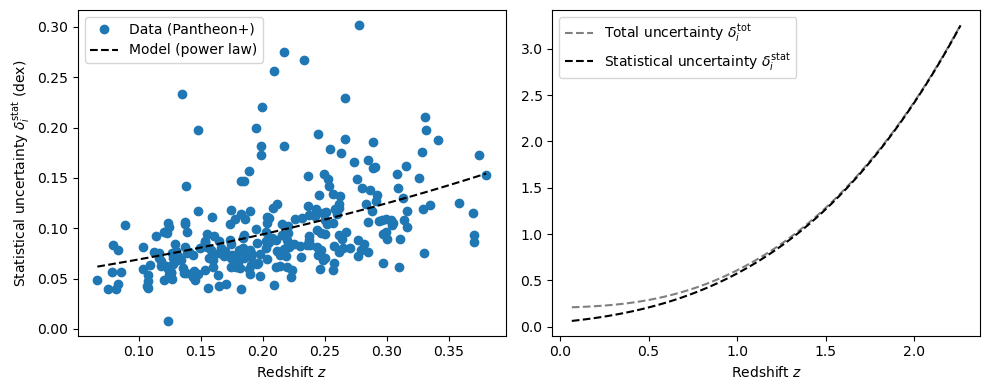

In [9]:
# ============================================================
# MODELLING LOG-MASS UNCERTAINTY
# ============================================================


### Fit model ###
set_model = 'power-law' # options: 'linear', 'power-law'

if set_model == 'linear':

    # Model: y = m x + b
    (p, cov) = np.polyfit(z_mask, err_logmass_mask_orig, deg=1, cov=True)
    m, b = p
    dm, db = np.sqrt(np.diag(cov))  # 1σ errors
    
    print(f"sigma log-mass = ({m:.4g} ± {dm:.4g}) z + ({b:.4g} ± {db:.4g})")
    
    # Set up grids
    zgrid = np.linspace(z_mask[0], z_mask[-1], 100)
    err_logmass_fit = m * zgrid + b
    
    zgrid_full = np.linspace(z_mask[0], np.max(z), 100)

    def get_err_logmass_stat(z_val):
        return m * z_val + b

    def get_err_logmass_tot(z_val):
        err_logmass_stat = get_err_logmass_stat(z_val)
        err_logmass_tot = np.sqrt(err_logmass_stat**2 + err_logmass_method**2)
        return err_logmass_tot
    
    err_logmass_fit_full = get_err_logmass_stat(zgrid_full)
    err_logmass_fit_tot = get_err_logmass_tot(zgrid_full)

elif set_model == 'power-law':

    # Model: sigma log-mass = c (1 + z)^n
    def model(z, c, n):
        return c * np.power(1.0 + z, n)
    
    pos = err_logmass_mask_orig > 0
    if pos.any():
        X = np.log1p(z_mask[pos]) # log(1+x)
        Y = np.log(err_logmass_mask_orig[pos]) # log y
        a, b = np.polyfit(X, Y, 1) # Y ≈ a*X + b  -> n≈a, c≈e^b
        p0 = (np.exp(b), a)
    else:
        p0 = (np.nanmax(y), 0.0) # fallback guess
    
    popt, pcov = curve_fit(model, z_mask, err_logmass_mask_orig, p0=p0, bounds=(0, np.inf)) # c≥0
    c_hat, n_hat = popt
    perr = np.sqrt(np.diag(pcov)) # 1σ errors
    dc, dn = perr
    
    print(f"y = c (1+x)^n with c = {c_hat:.4g} ± {dc:.4g}, n = {n_hat:.4g} ± {dn:.4g}")
    
    # Set up grids
    zgrid = np.linspace(z_mask[0], z_mask[-1], 100)
    err_logmass_fit = c_hat * (1.0 + zgrid)**n_hat
    
    zgrid_full = np.linspace(z_mask[0], np.max(z), 100)
    
    def get_err_logmass_stat(z_val):
        return c_hat * (1.0 + z_val)**n_hat

    def get_err_logmass_tot(z_val):
        err_logmass_stat = get_err_logmass_stat(z_val)
        err_logmass_tot = np.sqrt(err_logmass_stat**2 + err_logmass_method**2)
        return err_logmass_tot

    err_logmass_fit_full = get_err_logmass_stat(zgrid_full)
    err_logmass_fit_tot = get_err_logmass_tot(zgrid_full)


### Plot ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(z_mask, err_logmass_mask_orig, 'o')
ax1.plot(zgrid, err_logmass_fit, '--', color='black')
ax1.set_xlabel(r'Redshift $z$')
ax1.set_ylabel(r'Statistical uncertainty $\delta_i^\mathrm{stat}$ (dex)')
if set_model == 'linear':
    ax1.legend([r'Data (Pantheon+)', r'Model (linear)'])
elif set_model == 'power-law':
    ax1.legend([r'Data (Pantheon+)', r'Model (power law)'])
ax1.tick_params(axis='both')

ax2.plot(zgrid_full, err_logmass_fit_tot, '--', color='gray')
ax2.plot(zgrid_full, err_logmass_fit_full, '--', color='black')
ax2.set_xlabel(r'Redshift $z$')
ax2.legend([r'Total uncertainty $\delta_i^\mathrm{tot}$',
            r'Statistical uncertainty $\delta_i^\mathrm{stat}$'])
ax2.tick_params(axis='both')

plt.tight_layout()
plt.savefig('./plots/logmass_uncertainty_' + file_postfix + '.pdf')
plt.show()


## Cosmology Utilities

We compute $\mu(z)$ under flat or curved $\Lambda$CDM. The helper `mu(z, ...)` returns $\mu - 5\log_{10}(c/H_0\,\mathrm{Mpc}^{-1})$; the full $\mu$ for HF SNe is formed by adding $5\log_{10}(c/H_0)$ elsewhere.


In [10]:
# ============================================================
# COSMOLOGY UTILITIES (ΛCDM)
# ============================================================

def E(z, Omega_m, Omega_k):
    """Dimensionless H(z)/H0 for ΛCDM."""
    return np.sqrt( Omega_m*(1.0 + z)**3 + Omega_k*(1.0 + z)**2 + (1.0 - Omega_m - Omega_k) )


def D_L(z, Omega_m, Omega_k, nsteps_per_interval=10**3):
    """
    Dimensionless luminosity distance at the points of input z.
    Assumes z is sorted ascending.
    """
    z = np.atleast_1d(z).astype(float)
    if np.any(np.diff(z) < 0):
        raise ValueError("z must be sorted ascending")

    chi = np.empty_like(z)
    acc = 0.0
    z_prev = 0.0

    for i, zk in enumerate(z):
        dz = zk - z_prev
        n = max(1, int(np.ceil(nsteps_per_interval * dz)))
        grid = np.linspace(z_prev, zk, n + 1)
        f = 1.0 / E(grid, Omega_m, Omega_k)
        acc += np.trapz(f, grid)
        chi[i] = acc
        z_prev = zk

    if Omega_k == 0.0:
        chi = chi
    elif Omega_k > 0.0:
        chi = np.sinh( np.sqrt(Omega_k) * chi ) / np.sqrt(Omega_k)
    elif Omega_k < 0.0:
        chi = np.sin( np.sqrt(-Omega_k) * chi ) / np.sqrt(-Omega_k)

    dl = (1.0 + z) * chi

    return dl


def mu(z, Omega_m, Omega_k, ngrid=2048):
    """
    NB! µ - 5 log10(c / (H0 Mpc))
    """
    z = np.asarray(z, float)
    zmax = z.max()
    grid = np.linspace(0.0, zmax, ngrid)
    Ez = np.sqrt(Omega_m*(1+grid)**3 + Omega_k*(1+grid)**2 + (1.0 - Omega_m - Omega_k))
    chi_grid = cumulative_trapezoid(1.0/Ez, grid, initial=0.0)

    if Omega_k == 0.0:
        Sk = chi_grid
    elif Omega_k > 0.0:
        rt = np.sqrt(Omega_k)
        Sk = np.sinh(rt*chi_grid)/rt
    else:
        rt = np.sqrt(-Omega_k)
        Sk = np.sin(rt*chi_grid)/rt

    chi = np.interp(z, grid, Sk)
    
    return 5.0 * np.log10((1.0 + z)*chi)


## Mock Sample Generation

- **True** host masses are sampled from the Pantheon+ host-mass distribution;  
- **Observed** masses are drawn with Gaussian noise $\delta_i^\mathrm{tot}(z)$;  
- Calibrators use SH0ES Cepheid $\mu_i$ with quoted uncertainties;  
- Hubble flow uses $\mu_i$ from $\Lambda$CDM;  
- The mass step applies $-\gamma$ to $\mu$ for $\log_{10}M > \log_{10}M_\star$ (equivalent to $+ \gamma$ to $m_B$).


In [11]:
# ============================================================
# DATA POINTS: True values
# ============================================================

z_true = z

# Generating true host masses and uncertainties by sampling
logmass_distr = data_PP["HOST_LOGMASS"]
_, unique_idx = np.unique(logmass_distr, return_index=True) # remove duplicates
logmass_distr = logmass_distr[unique_idx]

# Keep only reasonable values and non-placeholders
mask = (logmass_distr > 8.0) & (logmass_distr != 10.0) & (logmass_distr != 11.5) & (logmass_distr < 12.0)
logmass_distr = logmass_distr[mask]

# Sample
logmass_true = np.random.choice(logmass_distr, len(z))
err_logmass_true = get_err_logmass_tot(z)

# Calculate the corrected (for stretch and color) B-band magnitude
step_true = np.where(logmass_true > logmass_star_true, -gamma_true, 0.0)
mB_true = mu(z_true, Omega_m_true, Omega_k_true) + M_intercept_true + step_true
mB_true[idx_Cal] = mu_Ceph_true[idx_Cal] + step_true[idx_Cal] + MB_true + 25.0 # overwrite values for Cal SNe 


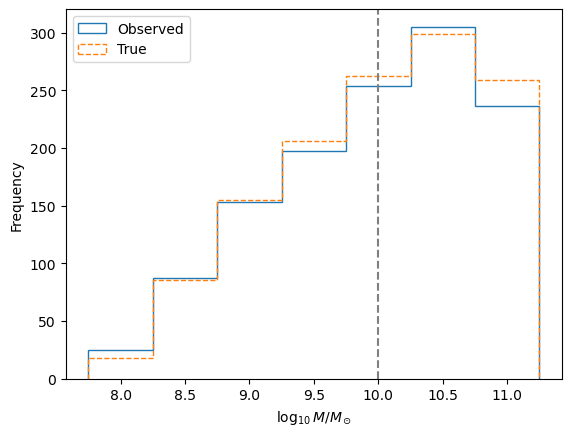

In [12]:
# ============================================================
# DATA POINTS: Observed values
# ============================================================

z_obs = z_true

logmass_obs = np.random.normal(loc=logmass_true, scale=err_logmass_true)
err_logmass_obs = err_logmass_true

mB_obs = np.random.normal(loc=mB_true, scale=err_mB_true)

# Observed Cepheid moduli for calibrators (HF have NaN)
mu_Ceph_obs = np.copy(mu_Ceph_true)
mu_Ceph_obs[idx_Cal] = np.random.normal(loc=mu_Ceph_true[idx_Cal], scale=err_mu_Ceph_true[idx_Cal])

# Plot the observed vs true mass distribution
bins = np.arange(7.75, 11.75, 0.5)

plt.hist(logmass_obs, histtype="step", bins=bins, label='Observed')
plt.hist(logmass_true, histtype="step", linestyle='--', bins=bins, label='True')
plt.axvline(x=logmass_star_true, linestyle='--', color='gray')
plt.xlabel(r'$\log_{10} M / M_\odot$')
plt.ylabel(r'Frequency')
plt.legend()

plt.savefig('./plots/logmass_distr_' + file_postfix + '.pdf')
plt.show()


In [13]:
# ============================================================
# PRIORS
# ============================================================

gamma_min, gamma_max               = [0.0, 0.5]
logmass_star_min, logmass_star_max = [7.0, 13.0]
MB_min, MB_max                     = [-20.0, -19.0]
H0_min, H0_max                     = [60.0, 80.0]
Omega_m_min, Omega_m_max           = [0.0, 1.0]
Omega_k_min, Omega_k_max           = [-0.5, 0.5]

_base_priors = np.array([
    [gamma_min,         gamma_max],
    [logmass_star_min,  logmass_star_max],
    [MB_min,            MB_max],
    [H0_min,            H0_max],
    [Omega_m_min,       Omega_m_max],
])

if incl_Omega_k:
    priors = np.vstack([_base_priors, [Omega_k_min, Omega_k_max]])
    labels = [r'$\gamma$ (mag)', r'$\log_{10} M_* / M_\odot$ (dex)', r'$M_B$ (mag)',
              r'$H_0$ (km/s/Mpc)', r'$\Omega_m$', r'$\Omega_k$']
else:
    priors = _base_priors
    labels = [r'$\gamma$ (mag)', r'$\log_{10} M_* / M_\odot$ (dex)',
              r'$M_B$ (mag)', r'$H_0$ (km/s/Mpc)', r'$\Omega_m$']


## Likelihoods

We split the log-likelihood into (i) a **Gaussian baseline** that keeps the full data covariance (diagonal approximation here), and (ii) a **binary-offset correction** treated by the **Ising paramagnetic** form:

$\Delta \ln\mathcal{L}\;=\;\tfrac12\,\mathrm{Tr}J\;+\;\sum_i \ln\!\left[p_i e^{h_i} + (1-p_i)\,e^{-h_i}\right],
\quad
h_i = -\frac{\gamma}{2}\,\frac{r_i}{\sigma_{\mathrm{tot},i}^2}$

with $p_i=\Pr(\log_{10}M^\mathrm{true}_i>\log_{10}M_\star\,|\,\log_{10}M_i,\sigma_{\log M,i})$.

We also run an **alternative (fixed)** fit that *ignores* $\log_{10} M$ uncertainties by classifying each SN deterministically relative to $\log_{10} M_\star$.


In [14]:
# ============================================================
# STATISTICAL FUNCTIONS
# ============================================================

def get_inv_var_SN():
    """Return 1/variance per SN (adds Cepheid μ uncertainty for calibrators)."""
    
    var_SN = np.full_like(z, fill_value=err_mB_true**2, dtype=float)
    var_SN[idx_Cal] += err_mu_Ceph_true[idx_Cal]**2
    inv_var_SN = 1. / var_SN
    
    return inv_var_SN


def _unpack(theta, incl_Omega_k=incl_Omega_k):
    """
    Return (gamma, logmass_star, MB, H0, Omega_m, Omega_k),
    with Omega_k=0 if not sampled.
    """
    
    if incl_Omega_k:
        gamma, logmass_star, MB, H0, Omega_m, Omega_k = theta
    else:
        gamma, logmass_star, MB, H0, Omega_m = theta
        Omega_k = 0.0
        
    return gamma, logmass_star, MB, H0, Omega_m, Omega_k


def p(logmass_star):
    """
    Probability that true logmass > logmass_star given observed values.
    """
    
    return 1.0 - norm.cdf(logmass_star, loc=logmass_obs, scale=err_logmass_obs)


def res(gamma, MB, H0, Omega_m, Omega_k, mu_z):
    """
    Residuals r_i for *all* SNe with a unified centering: subtract -gamma/2 on the mean.
    HF:   r_i = mB_obs - [ mu(z_i) + 25 + MB + 5 log10(c/H0) - gamma/2 ]
    CAL:  r_i = mB_obs - [ mu_Ceph_obs + 25 + MB             - gamma/2 ]   (no cosmology)
    """
    
    mB_mean = np.zeros_like(z)
    mB_mean[idx_Cal] = mu_Ceph_obs[idx_Cal]                 + 25.0 + MB - 0.5 * gamma
    mB_mean[idx_HF]  = mu_z + 5. * np.log10( c_light / H0 ) + 25.0 + MB - 0.5 * gamma
    
    return mB_obs - mB_mean


def Tr_J(gamma):
    """
    Here: J_ij = -(gamma / 2)^2 C^{-1}_ij
    """
    
    inv_var_SN = get_inv_var_SN()
    
    return -(gamma / 2.)**2 * np.sum(inv_var_SN)


def h(gamma, MB, H0, Omega_m, Omega_k, mu_z):
    """
    Here: h_i = -gamma / 2 * res_i / SN_variance
    """
    
    inv_var_SN = get_inv_var_SN()
    
    return -gamma / 2. * res(gamma, MB, H0, Omega_m, Omega_k, mu_z) * inv_var_SN


def log_prior(theta):
    # uniform box prior inside 'priors'
    if np.any(theta <= priors[:, 0]) or np.any(theta >= priors[:, 1]):
        return -np.inf

    # extra physical prior (kept even if Omega_k is fixed, it will just be 0)
    gamma, logmass_star, MB, H0, Omega_m, Omega_k = _unpack(theta)
    if Omega_k < -1.5 * Omega_m:  # ensures real-valued E(z) at all redshifts
        return -np.inf

    return 0.0


### Log-likelihood for Ising-marginalized calibration ###
def log_like_mean(gamma, MB, H0, Omega_m, Omega_k, mu_z):
    """
    ln L_mean = -1/2 res_i C^{-1}_{ij} res_j
    """

    r = res(gamma, MB, H0, Omega_m, Omega_k, mu_z)
    inv_var_SN = get_inv_var_SN()
    var_SN = 1.0 / inv_var_SN
    ln_det_C = np.sum(np.log(var_SN))
    
    return -0.5 * np.sum( r**2 * inv_var_SN ) - 0.5 * ln_det_C


def Delta_log_like(gamma, logmass_star, MB, H0, Omega_m, Omega_k, mu_z):
    """
    Ising paramagnetic correction in numerically stable log-sum form.
    """
    
    h_arr = h(gamma, MB, H0, Omega_m, Omega_k, mu_z)
    p_arr = p(logmass_star)

    # Returns sum_i log( p_i * exp(h_i) + (1 - p_i) * exp(-h_i) )
    # Safe for p=0 or p=1 using logaddexp + log1p.
    with np.errstate(divide="ignore"):
        logp   = np.log(p_arr)          # -inf if p=0
        log1mp = np.log1p(-p_arr)       # -inf if p=1
    log_mixture_term = np.sum(np.logaddexp(logp + h_arr, log1mp - h_arr))
    
    return 0.5 * Tr_J(gamma) + log_mixture_term


def log_like(theta):
    """
    ln L = ln L_mean + Delta ln L
    """

    gamma, logmass_star, MB, H0, Omega_m, Omega_k = _unpack(theta)
    mu_z = mu(z[idx_HF], Omega_m, Omega_k) # only for HF SNe

    return log_like_mean(gamma, MB, H0, Omega_m, Omega_k, mu_z) + Delta_log_like(gamma, logmass_star, MB, H0, Omega_m, Omega_k, mu_z)


def log_prob(theta):
    """
    ln P = ln L + ln π
    """
    
    lp = log_prior(theta)
    
    if not np.isfinite(lp): # last condition: ensuring real-valued E(z)
        return -np.inf
    else:
        return lp + log_like(theta)


### Log-likelihood for alternative (fixed host-mass) calibration ###
def step_from_observed(gamma, logmass_star):
    
    """Mass-step computed from *observed* host masses."""
    
    return np.where(logmass_obs > logmass_star, gamma, 0.0)


def log_like_alternative(theta):
    """
    Gaussian likelihood neglecting uncertainties in the log masses.
    """
    
    gamma, logmass_star, MB, H0, Omega_m, Omega_k = _unpack(theta)
    
    mu_z = mu(z[idx_HF], Omega_m, Omega_k) # only for HF SNe
    step = step_from_observed(gamma, logmass_star)
    inv_var_SN = get_inv_var_SN()
    var_SN = 1.0 / inv_var_SN
    ln_det_C = np.sum(np.log(var_SN))

    r = np.zeros_like(z)
    r[idx_Cal] = mB_obs[idx_Cal] - (mu_Ceph_obs[idx_Cal] + 25.0 + MB - step[idx_Cal]) # Cal SNe
    r[idx_HF]  = mB_obs[idx_HF]  - (mu_z                 + 25.0 + MB - step[idx_HF] + 5. * np.log10( c_light / H0 )) # HF SNe
    
    return -0.5 * np.sum(r**2 * inv_var_SN) - 0.5 * ln_det_C


def log_prob_alternative(theta):
    """
    ln P = ln L + ln π
    """
    
    lp = log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like_alternative(theta)


## MCMC & Posteriors

We sample with `emcee` using a small mixture of moves and report chain diagnostics (autocorrelation, runtime). Posteriors are visualized with `corner`.


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:50<00:00, 86.64it/s]


Converged: True
emcee finished in 230.9 sec with 20000 iterations
100 x autocorrelation time = 13546.1


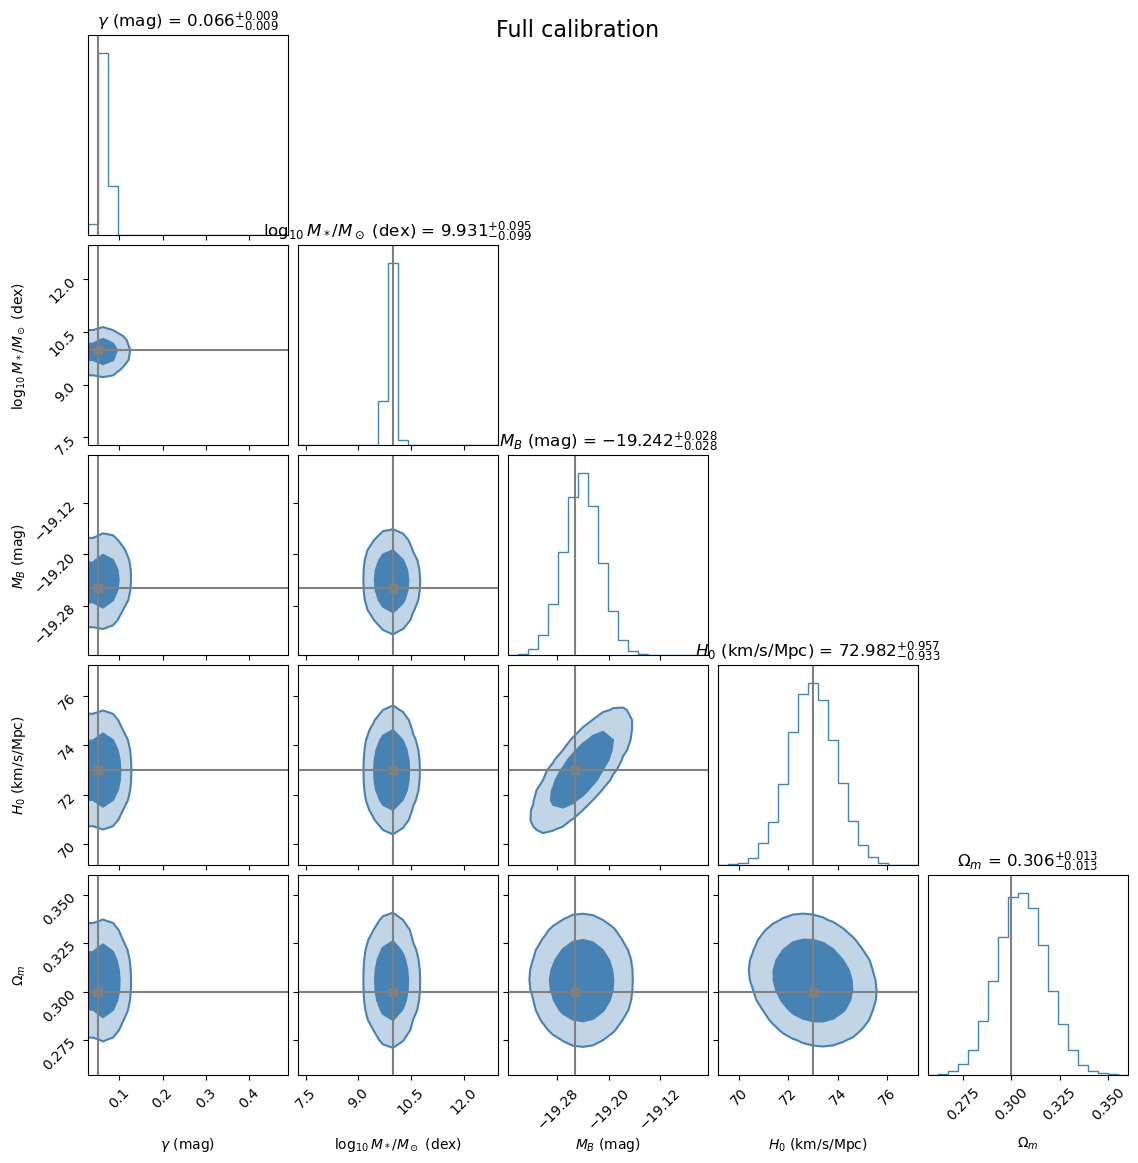

In [15]:
# ============================================================
# RUN MCMC: Ising marginalization
# ============================================================

### MCMC Settings ###
ndim = priors.shape[0]
mymove = [(emcee.moves.StretchMove(),    0.6), # avoid getting stuck in local basins
         (emcee.moves.DEMove(),          0.3),
         (emcee.moves.DESnookerMove(),   0.1)]
nwalk = 4 * ndim

### Initial guess for each walker ###
theta0 = np.random.uniform(priors[:, 0], priors[:, 1], size=(nwalk, ndim))

### Run MCMC ###
start = time.time()
sampler = emcee.EnsembleSampler(nwalk, ndim, log_prob, moves = mymove)
sampler.run_mcmc(theta0, nsteps = max_n, progress = True) # skip_initial_state_check=True
end = time.time()

### Post processing ###
try:
    tau = sampler.get_autocorr_time(tol=0)
    autocorr = float(np.max(tau))
    burnin = int(2 * np.max(tau))
    thin = max(1, int(0.5 * np.min(tau)))
    converged_flag = (max_n > 100.0 * autocorr)
    run_time = end - start
    if converged_flag:
        print('Converged: True')
    else:
        print('Converged: False')
    print('emcee finished in %.1f sec with %.0f iterations' % (run_time, max_n))
    print('100 x autocorrelation time = %.1f' % (100. * autocorr))

except Exception as e:
    print(f"Warning: autocorr failed ({e}). Falling back to heuristics.")
    autocorr = np.nan
    burnin = max(500, int(0.1 * max_n))
    thin = 10
    converged_flag = False

flatchain = sampler.get_chain(discard=burnin, flat=True, thin=thin)

### Plot posterior ###
_base_truths = [gamma_true, logmass_star_true, MB_true, H0_true, Omega_m_true]
if incl_Omega_k:
    truths = np.vstack([_base_truths, Omega_k_true])
else:
    truths = _base_truths

fig = corner.corner(
    flatchain,
    levels = [0.68, 0.95], # credence regions
    show_titles = True,
    plot_datapoints = False,
    fill_contours = True,
    smooth = 1.0,
    color = 'steelblue',
    title_fmt = '.3f',
    title_kwargs = {"fontsize": 12},
    labels=labels,
    truths=truths,
    truth_color='gray')

fig.suptitle('Full calibration', fontsize=16)

plt.savefig('./plots/corner_' + file_postfix + '.pdf')
plt.show()


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:04<00:00, 160.47it/s]


Converged: True
emcee finished in 124.7 sec with 20000 iterations
100 x autocorrelation time = 9398.1


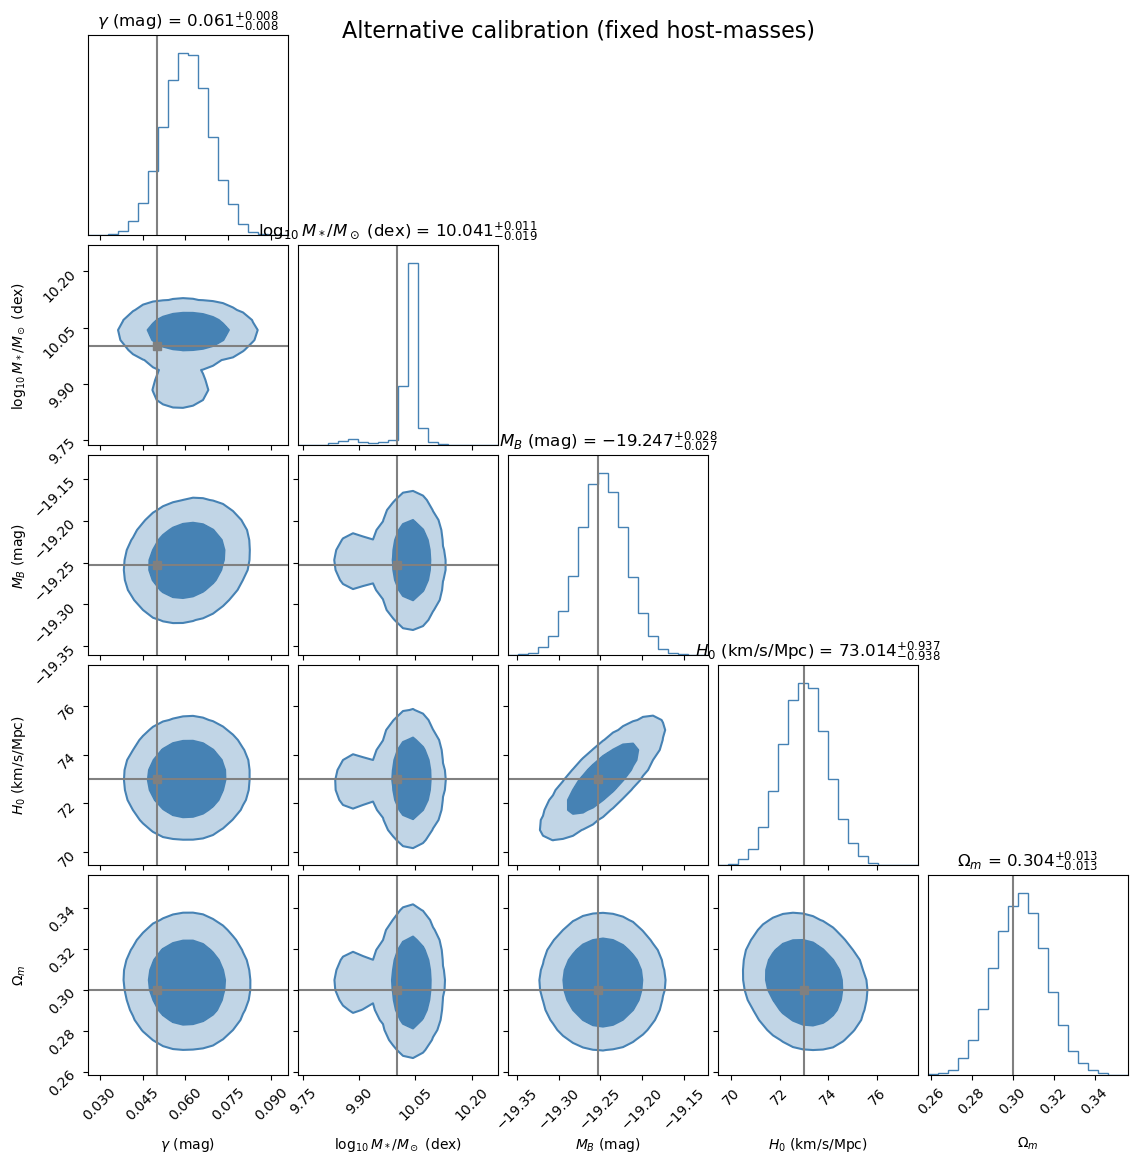

In [16]:
# ============================================================
# RUN MCMC: Alternative calibration = Fixed masses
# ============================================================
    
### Initial guess for each walker ###
theta0 = np.random.uniform(priors[:, 0], priors[:, 1], size=(nwalk, ndim))

### Run MCMC ###
start = time.time()
sampler = emcee.EnsembleSampler(nwalk, ndim, log_prob_alternative, moves = mymove)
sampler.run_mcmc(theta0, nsteps = max_n, progress = True) # skip_initial_state_check=True
end = time.time()

### Post processing ###
try:
    tau = sampler.get_autocorr_time(tol=0)
    autocorr_alternative = float(np.max(tau))
    burnin = int(2 * np.max(tau))
    thin = max(1, int(0.5 * np.min(tau)))
    converged_flag = (max_n > 100.0 * autocorr_alternative)
    run_time_alternative = end - start
    if converged_flag:
        print('Converged: True')
    else:
        print('Converged: False')
    print('emcee finished in %.1f sec with %.0f iterations' % (run_time, max_n))
    print('100 x autocorrelation time = %.1f' % (100. * autocorr_alternative))

except Exception as e:
    print(f"Warning: autocorr failed ({e}). Falling back to heuristics.")
    autocorr_alternative = np.nan
    burnin = max(500, int(0.1 * max_n))
    thin = 10
    converged_flag = False

flatchain_alternative = sampler.get_chain(discard=burnin, flat=True, thin=thin)

### Plot posterior ###
fig = corner.corner(
    flatchain_alternative,
    levels = [0.68, 0.95], # credence regions
    show_titles = True,
    plot_datapoints = False,
    fill_contours = True,
    smooth = 1.0,
    color = 'steelblue',
    title_fmt = '.3f',
    title_kwargs = {"fontsize": 12},
    labels=labels,
    truths=truths,
    truth_color='gray')

fig.suptitle('Alternative calibration (fixed host-masses)', fontsize=16)

plt.savefig('./plots/corner_Alt_' + file_postfix + '.pdf')
plt.show()


## Diagnostics & Artifacts

We log chain diagnostics, misclassification rates relative to the *true* mass threshold, and write chains/diagnostics to `output/`. Figures are saved under `plots/`.


In [19]:
# ============================================================
# DIAGNOSTICS: Save results
# ============================================================

### Host-mass misclassifications (observed vs true) ###
true_side = (logmass_true > logmass_star_true)
obs_side  = (logmass_obs  > logmass_star_true)
mask_wrong = (true_side != obs_side)

n_total = len(logmass_true)
n_wrong = np.sum(mask_wrong)
frac_wrong = n_wrong / n_total

mask_true_above_obs_below = (true_side) & (~obs_side)
mask_true_below_obs_above = (~true_side) & (obs_side)

n_above_to_below = np.sum(mask_true_above_obs_below)
n_below_to_above = np.sum(mask_true_below_obs_above)

print(f"Total SNe                = {n_total}")
print(f"Misclassified (any side) = {n_wrong} ({100*frac_wrong:.1f}%)")
print(f"True above → Obs below   = {n_above_to_below}")
print(f"True below → Obs above   = {n_below_to_above}")

### Save diagnostics ###
if max_n > (100. * autocorr):
    converged = 'Full calibration\n--------------------------------------------------\nConverged = True'
else:
    converged = 'Full calibration\n--------------------------------------------------\nConverged = False'
time_diag = 'emcee finished in %.1f sec with %.0f iterations' % (run_time, max_n)
autocorr_diag = '100 x autocorrelation time = %.0f' % (100. * autocorr)

if max_n > (100. * autocorr_alternative):
    converged_alternative = 'Alternative calibration\n--------------------------------------------------\nConverged = True'
else:
    converged_alternative = 'Alternative calibration\n--------------------------------------------------\nConverged = False'
time_diag_alternative = 'emcee finished in %.1f sec with %.0f iterations' % (run_time_alternative, max_n)
autocorr_diag_alternative = '100 x autocorrelation time = %.0f' % (100. * autocorr_alternative)
err_logmass_method_str = 'Method-uncertainty in log mass = %.2f dex' % err_logmass_method

mass_diag_1 = f"Total SNe                = {n_total}"
mass_diag_2 = f"Misclassified (any side) = {n_wrong} ({100*frac_wrong:.1f}%)"
mass_diag_3 = f"True above -> Obs below  = {n_above_to_below}"
mass_diag_4 = f"True below -> Obs above  = {n_below_to_above}"

diag_str = converged + '\n' + time_diag + '\n' + autocorr_diag + '\n\n' + converged_alternative + '\n' +\
           time_diag_alternative + '\n' + autocorr_diag_alternative + '\n\n' + err_logmass_method_str + '\n\n' +\
           mass_diag_1 + '\n' + mass_diag_2 + '\n' + mass_diag_3 + '\n' + mass_diag_4

np.savetxt('./output/diagnostics_' + file_postfix + '.txt', np.array([diag_str]), fmt='%s')

np.savetxt('./output/flatchain_' + file_postfix + '.txt', flatchain, fmt = '%.5f', delimiter = '\t', newline = '\n')
np.savetxt('./output/flatchain_Alt_' + file_postfix + '.txt', flatchain_alternative, fmt = '%.5f', delimiter = '\t', newline = '\n')
    

Total SNe                = 1351
Misclassified (any side) = 103 (7.6%)
True above → Obs below   = 72
True below → Obs above   = 31
